In [ ]:
!pip install pyspatialml
!pip install shap

In [ ]:
from pyspatialml import Raster
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pandas as pd
import shap
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score,f1_score,classification_report,confusion_matrix



In [ ]:
os.chdir('/content/drive/MyDrive/MC_NEW-20221123T154430Z-001/MC_NEW/ML_GROUP-20230119T153151Z-001/Landslide GeoEnvironmental Parameters -Gangotri')
os.listdir()

['LULC.tfw',
 'LULC.tif.ovr',
 'LULC.tif',
 'LULC.tif.vat.cpg',
 'LULC.tif.aux.xml',
 'LULC.tif.vat.dbf',
 'geo.tif.vat.dbf',
 'geo.tif',
 'geo.tif.vat.cpg',
 'geo.tif.ovr',
 'geo.tfw',
 'geo.tif.aux.xml',
 'litho.tif.vat.cpg',
 'litho.tfw',
 'litho.tif.vat.dbf',
 'litho.tif.aux.xml',
 'litho.tif',
 'litho.tif.ovr',
 'aspect.tfw',
 'aspect.tif.ovr',
 'aspect.tif.aux.xml',
 'aspect.tif',
 'slope.tfw',
 'slope.tif.ovr',
 'slope.tif',
 'slope.tif.aux.xml',
 'road.tfw',
 'road.tif.aux.xml',
 'road.tif.ovr',
 'road.tif',
 'twi.tfw',
 'twi.tif',
 'twi.tif.aux.xml',
 'twi.tif.ovr',
 'DD.tfw',
 'DD.tif.aux.xml',
 'DD.tif.ovr',
 'DD.tif',
 'LD.tfw',
 'LD.tif.aux.xml',
 'LD.tif',
 'LD.tif.ovr',
 'ndvi_T.tfw',
 'ndvi_T.tif.ovr',
 'ndvi_T.tif',
 'ndvi_T.tif.aux.xml',
 'Points',
 'loss_curve.jpeg',
 'shap_dependence_slope.png',
 'shap_dependence_aspect.png',
 'shap_dependence_DD.png',
 'shap_dependence_twi.png',
 'shap_dependence_road.png',
 'shap_dependence_Road.png',
 'shap_dependence_TWI.png',
 

In [ ]:
predictors = ['geo.tif','road.tif','litho.tif','LD.tif','ndvi_T.tif', 'twi.tif', 'LULC.tif', 'slope.tif', 'aspect.tif','DD.tif']

In [ ]:
stack = Raster(predictors)

In [ ]:
stack.count

10

In [ ]:
vf = gpd.read_file('/content/drive/MyDrive/MC_NEW-20221123T154430Z-001/MC_NEW/training/training.shp')

Raster Object Containing 10 Layers
    attribute                                             values
0       names  [geo, road, litho, LD, ndvi_T, twi, LULC, slop...
1       files  [geo.tif, road.tif, litho.tif, LD.tif, ndvi_T....
2        rows                                               7204
3        cols                                               9778
4         res              (9.99995258800289, 9.999952588002905)
5  nodatavals  [127.0, -3.4028230607370965e+38, 127.0, -3.402...


In [ ]:
vf.head(2)

,Id,geometry
0,1,"POLYGON Z ((243347.149 3388732.622 0.000, 2433..."
1,1,"POLYGON Z ((243306.724 3388876.132 0.000, 2432..."


In [ ]:
vf_points = vf.centroid

In [ ]:
df = stack.extract_vector(vf_points)

Raster Object Containing 10 Layers
    attribute                                             values
0       names  [geo, road, litho, LD, ndvi_T, twi, LULC, slop...
1       files  [geo.tif, road.tif, litho.tif, LD.tif, ndvi_T....
2        rows                                               7204
3        cols                                               9778
4         res              (9.99995258800289, 9.999952588002905)
5  nodatavals  [127.0, -3.4028230607370965e+38, 127.0, -3.402...
Raster Object Containing 10 Layers
    attribute                                             values
0       names  [geo, road, litho, LD, ndvi_T, twi, LULC, slop...
1       files  [geo.tif, road.tif, litho.tif, LD.tif, ndvi_T....
2        rows                                               7204
3        cols                                               9778
4         res              (9.99995258800289, 9.999952588002905)
5  nodatavals  [127.0, -3.4028230607370965e+38, 127.0, -3.402...
Raster Object Contai

In [ ]:
df.head(2)

,,geo,road,litho,LD,ndvi_T,twi,LULC,slope,aspect,DD,geometry
pixel_idx,geometry_idx,,,,,,,,,,,
0,0,2.0,0.0,6.0,0.080195,0.289495,4.511374,5.0,39.480736,280.491486,1.919997,POINT (243415.688 3388815.168)
1,1,2.0,0.0,6.0,0.080195,0.824188,2.323761,5.0,50.747879,247.416153,1.907240,POINT (243401.535 3388968.361)


In [ ]:
df_points = df.merge(
    right=vf.loc[:, ["Id"]],
    left_on="geometry_idx",
    right_on="index",
    right_index=True
)

In [ ]:
df_points.head(-5)

,,geo,road,litho,LD,ndvi_T,twi,LULC,slope,aspect,DD,geometry,Id
pixel_idx,geometry_idx,,,,,,,,,,,,
0,0,2.0,0.000000,6.0,0.080195,0.289495,4.511374,5.0,39.480736,280.491486,1.919997,POINT (243415.688 3388815.168),1
1,1,2.0,0.000000,6.0,0.080195,0.824188,2.323761,5.0,50.747879,247.416153,1.907240,POINT (243401.535 3388968.361),1
2,2,2.0,0.000000,6.0,0.080195,0.863234,10.141537,5.0,35.780071,240.945389,1.894235,POINT (243331.416 3389101.021),1
3,3,2.0,0.000000,4.0,0.235854,0.346268,5.166389,7.0,38.113274,78.976547,1.836945,POINT (243785.521 3392278.366),1
4,4,2.0,288.133026,4.0,0.219220,0.769076,8.427302,7.0,42.328003,81.158188,1.830692,POINT (243752.100 3392170.022),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,127,12.0,12101.586914,2.0,0.291925,0.029011,2.974386,6.0,68.618256,127.363426,0.355314,POINT (287906.788 3448551.223),0
128,128,0.0,19071.271484,1.0,0.022135,-0.050764,4.743695,5.0,18.081682,62.650124,2.863844,POINT (320051.377 3412196.494),0
129,129,5.0,13905.217773,1.0,0.136010,-0.058834,4.208986,6.0,29.131578,80.706688,0.481801,POINT (303204.809 3417449.433),0


In [ ]:
df_r = df_points.drop(columns =['geometry','Id'])
df_r.head(2)
df_r.reset_index(drop=True)



,geo,road,litho,LD,ndvi_T,twi,LULC,slope,aspect,DD
0,2.0,0.000000,6.0,0.080195,0.289495,4.511374,5.0,39.480736,280.491486,1.919997
1,2.0,0.000000,6.0,0.080195,0.824188,2.323761,5.0,50.747879,247.416153,1.907240
2,2.0,0.000000,6.0,0.080195,0.863234,10.141537,5.0,35.780071,240.945389,1.894235
3,2.0,0.000000,4.0,0.235854,0.346268,5.166389,7.0,38.113274,78.976547,1.836945
4,2.0,288.133026,4.0,0.219220,0.769076,8.427302,7.0,42.328003,81.158188,1.830692
...,...,...,...,...,...,...,...,...,...,...
132,7.0,17915.294922,2.0,0.000000,-0.117570,5.367736,1.0,3.337111,210.963760,0.747359
133,5.0,19478.304688,1.0,0.139481,NaN,5.843851,6.0,28.516256,6.340192,0.152507
134,5.0,18449.515625,1.0,0.295252,-0.018452,6.339057,6.0,40.726139,2.663001,0.181959
135,6.0,0.000000,0.0,0.324770,0.680624,7.365918,1.0,1.811248,161.565048,1.624501


In [ ]:
df_r['ndvi_T'].isna().sum()

df_corr = df_r.dropna()
df_corr['ndvi_T'].isna().sum()


0

Raster Object Containing 10 Layers
    attribute                                             values
0       names  [geo, road, litho, LD, ndvi_T, twi, LULC, slop...
1       files  [geo.tif, road.tif, litho.tif, LD.tif, ndvi_T....
2        rows                                               7204
3        cols                                               9778
4         res              (9.99995258800289, 9.999952588002905)
5  nodatavals  [127.0, -3.4028230607370965e+38, 127.0, -3.402...


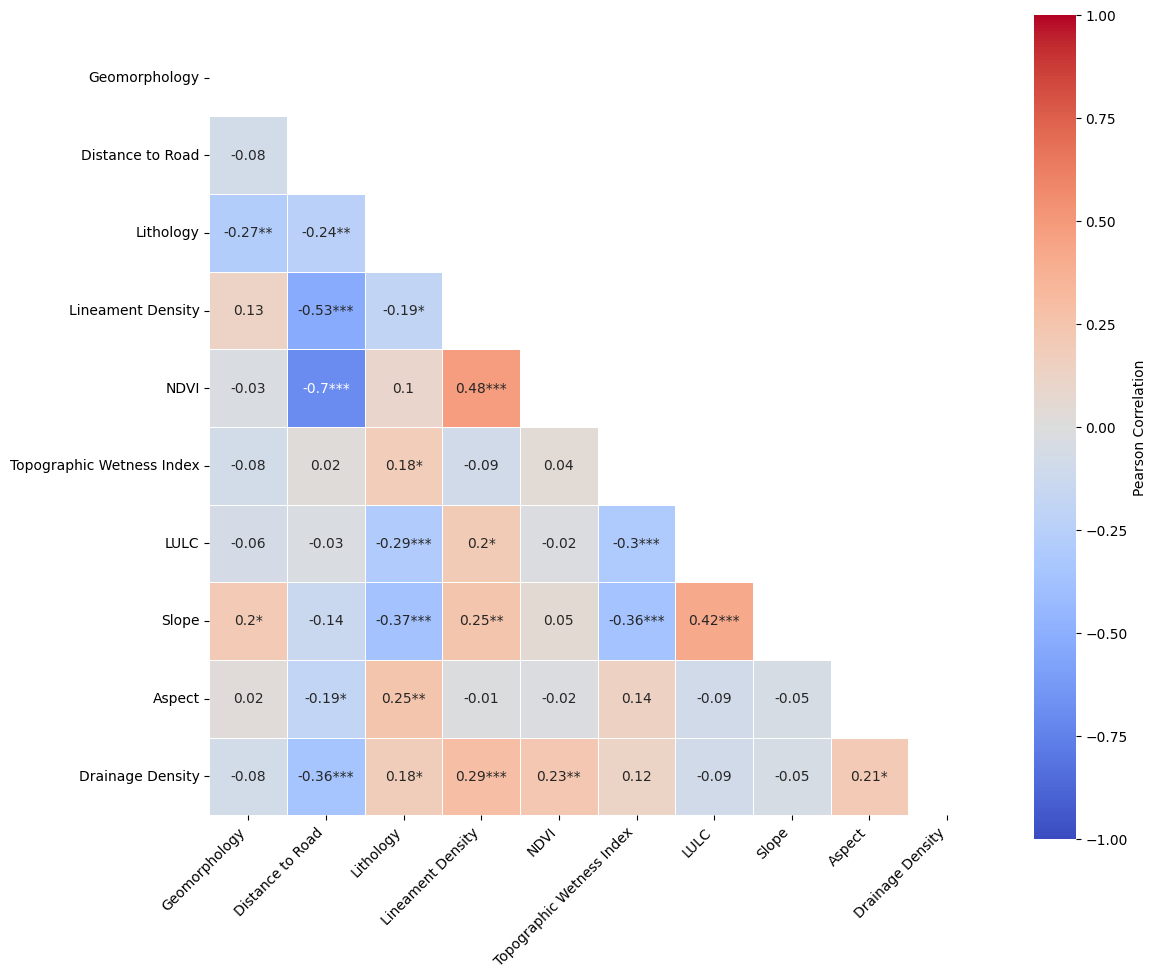

In [ ]:

def calculate_corr_pvalues(df):
    cols = df.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)
    p_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for i in cols:
        for j in cols:
            if i != j:
                corr, pval = pearsonr(df[i], df[j])
                corr_matrix.loc[i, j] = corr
                p_matrix.loc[i, j] = pval
            else:
                corr_matrix.loc[i, j] = np.nan
                p_matrix.loc[i, j] = np.nan
    return corr_matrix, p_matrix

corr_matrix, p_matrix = calculate_corr_pvalues(df_corr)


def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

labels = corr_matrix.round(2).astype(str)
for i in corr_matrix.columns:
    for j in corr_matrix.index:
        pval = p_matrix.loc[j, i]
        if pd.notnull(pval):
            labels.loc[j, i] += significance_stars(pval)
        else:
            labels.loc[j, i] = ''

rename_dict = {
    'geo': 'Geomorphology',
    'road': 'Distance to Road',
    'litho': 'Lithology',
    'LD': 'Lineament Density',
    'ndvi_T': 'NDVI',
    'twi': 'Topographic Wetness Index',
    'LULC': 'LULC',
    'slope': 'Slope',
    'aspect': 'Aspect',
    'DD': 'Drainage Density'
}


corr_matrix.rename(columns=rename_dict, index=rename_dict, inplace=True)
labels.rename(columns=rename_dict, index=rename_dict, inplace=True)


mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.astype(float),
            mask=mask,
            annot=labels,
            fmt='',
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=.5,
            cbar_kws={"label": "Pearson Correlation"})


plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Useful for writing and knowledge papers/correlation_significance.jpeg',dpi = 400)
plt.show()


In [ ]:
df_c = df_points.drop(columns =['geometry'])

NameError: name 'df_points' is not defined

In [ ]:
df_c.isnull().sum()
df_c.dropna()
df_c.reset_index(drop=True)

In [ ]:
mlfile = df_c.to_csv('/content/drive/MyDrive/MC_NEW-20221123T154430Z-001/mfile.csv',index =False)



NameError: name 'df_c' is not defined

Data Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MC_NEW-20221123T154430Z-001/mfile.csv')

In [ ]:
df = df.rename(columns={'geo': 'Geomorphology', 'road': 'Road','litho': 'Lithology','LD': 'Lineament Density','ndvi_T': 'NDVI','twi': 'TWI','LULC': 'LULC','slope': 'Slope','aspect': 'Aspect','DD': 'Drainage Density'})

In [ ]:
df.isnull().sum()

,0
Geomorphology,0
Road,0
Lithology,0
Lineament Density,0
NDVI,9
TWI,0
LULC,0
Slope,0
Aspect,0
Drainage Density,0


In [ ]:
df_1 = df.dropna()
df_1 =df_1.reset_index(drop =True)

In [ ]:
x = df_1.iloc[:,:-1]
y = df_1.iloc[:,-1]

In [ ]:
x

,Geomorphology,Road,Lithology,Lineament Density,NDVI,TWI,LULC,Slope,Aspect,Drainage Density
0,2.0,0.000000,6.0,0.080195,0.289495,4.511374,5.0,39.480736,280.491486,1.919997
1,2.0,0.000000,6.0,0.080195,0.824188,2.323761,5.0,50.747879,247.416153,1.907240
2,2.0,0.000000,6.0,0.080195,0.863234,10.141537,5.0,35.780071,240.945389,1.894235
3,2.0,0.000000,4.0,0.235854,0.346268,5.166389,7.0,38.113274,78.976547,1.836945
4,2.0,288.133026,4.0,0.219220,0.769076,8.427302,7.0,42.328003,81.158188,1.830692
...,...,...,...,...,...,...,...,...,...,...
123,1.0,0.000000,5.0,0.357067,0.716564,4.978884,7.0,4.916666,125.537682,1.929242
124,7.0,17915.294922,2.0,0.000000,-0.117570,5.367736,1.0,3.337111,210.963760,0.747359
125,5.0,18449.515625,1.0,0.295252,-0.018452,6.339057,6.0,40.726139,2.663001,0.181959
126,6.0,0.000000,0.0,0.324770,0.680624,7.365918,1.0,1.811248,161.565048,1.624501


In [ ]:
y

,Id
0,1
1,1
2,1
3,1
4,1
...,...
123,0
124,0
125,0
126,0


In [ ]:
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)

In [ ]:
x_train

,Geomorphology,Road,Lithology,Lineament Density,NDVI,TWI,LULC,Slope,Aspect,Drainage Density
65,1.0,0.000000,5.0,0.179605,0.641744,11.731154,4.0,4.916666,234.462326,2.083874
32,4.0,288.133026,0.0,0.382955,0.770637,3.259284,7.0,25.650703,121.373009,1.635906
7,2.0,576.266052,4.0,0.430776,0.771377,4.320223,7.0,44.922440,243.178024,1.532415
111,4.0,0.000000,0.0,0.354652,0.544536,3.540502,7.0,19.925144,65.556046,1.580447
2,2.0,0.000000,6.0,0.080195,0.863234,10.141537,5.0,35.780071,240.945389,1.894235
...,...,...,...,...,...,...,...,...,...,...
123,1.0,0.000000,5.0,0.357067,0.716564,4.978884,7.0,4.916666,125.537682,1.929242
57,7.0,4500.781738,2.0,0.356101,0.158199,6.099759,7.0,26.783602,236.309937,2.368973
44,2.0,1551.643799,2.0,0.347573,0.162880,2.585485,5.0,43.289886,232.765167,1.719779
82,2.0,4725.732910,0.0,0.240435,0.208171,4.478957,7.0,29.565123,49.289154,0.224572


One hot encoding the categorical features

In [ ]:
geo_idx = list(stack.names).index("geo")
lulc_idx = list(stack.names).index("LULC")
litho_idx = list(stack.names).index("litho")
print( geo_idx, lulc_idx,litho_idx)


0 6 2


In [ ]:
categorical_features =[0,2,6]
numerical_features =[1,3,4,5,7,8,9]

In [ ]:

preprocessor = ColumnTransformer([
    ('ohe_soil', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)])


In [ ]:
!pip install xgboost
from xgboost import XGBClassifier
classifier = XGBClassifier(random_state=42, eval_metric='logloss')


ML-Pipeline

In [ ]:
xgb_flow = Pipeline([
    ('preproc', preprocessor),
    ('xg', classifier)
])

In [ ]:
acc_scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score)



params = {
    "xg__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "xg__max_depth": [3, 5, 7],
    "xg__min_child_weight": [1, 3, 5],
    "xg__colsample_bytree": [0.3, 0.5, 0.7],
    "xg__gamma": [0, 0.1, 0.5, 1],
    "xg__reg_lambda": [0.1, 1, 10],
    "xg__subsample": [0.6, 0.8, 1.0],
    "xg__n_estimators": [100, 150, 200]
}

# Instantiate the grid search model with 10-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_xgb = RandomizedSearchCV(
    estimator=xgb_flow,
    param_distributions=params,
    n_iter=30,  # Adjust depending on compute
    scoring=f1_scorer,
    cv=kfold,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


# Fit the grid search to the data
model_xgb.fit(x_train, y_train)
model_xgb.best_params_
val_preds = model_xgb.predict(x_val)

In [ ]:
# Instantiate the grid search model with 10-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_xgb = RandomizedSearchCV(
    estimator=xgb_flow,
    param_distributions=params,
    n_iter=30,  # Adjust depending on compute
    scoring=f1_scorer,
    cv=kfold,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


# Fit the grid search to the data
model_xgb.fit(x_train, y_train)
model_xgb.best_params_
val_preds = model_xgb.predict(x_val)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
print("Validation F1 Score:", f1_score(y_val, val_preds))
print("Validation Classification Report:\n", classification_report(y_val, val_preds))
print("Validation Accuracy:", accuracy_score(y_val, val_preds))

Validation F1 Score: 0.8888888888888888
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.86      0.92      0.89        13

    accuracy                           0.88        26
   macro avg       0.89      0.88      0.88        26
weighted avg       0.89      0.88      0.88        26

Validation Accuracy: 0.8846153846153846


In [ ]:
model_xgb.best_params_

{'xg__subsample': 0.8,
 'xg__reg_lambda': 0.1,
 'xg__n_estimators': 200,
 'xg__min_child_weight': 1,
 'xg__max_depth': 7,
 'xg__learning_rate': 0.05,
 'xg__gamma': 0,
 'xg__colsample_bytree': 0.5}

In [ ]:

y_pred_xg_prob = model_xgb.predict_proba(x_test)
y_pred_xg_prob = y_pred_xg_prob[:,1]
test_preds = model_xgb.best_estimator_.predict(x_test)



In [ ]:
print("Test F1 Score:", f1_score(y_test, test_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))

print("\nTest Classification Report:\n", classification_report(y_test, test_preds))

Test F1 Score: 0.9333333333333333
Test Accuracy: 0.9230769230769231

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.88      1.00      0.93        14

    accuracy                           0.92        26
   macro avg       0.94      0.92      0.92        26
weighted avg       0.93      0.92      0.92        26



In [ ]:
!profile.update(BIGTIFF = "IF_SAFER")

/bin/bash: -c: line 1: syntax error near unexpected token `BIGTIFF'
/bin/bash: -c: line 1: `profile.update(BIGTIFF = "IF_SAFER")'


In [ ]:
import warnings

warnings.filterwarnings("ignore")

array([<Axes: title={'center': 'prob_0'}>,
       <Axes: title={'center': 'prob_1'}>], dtype=object)

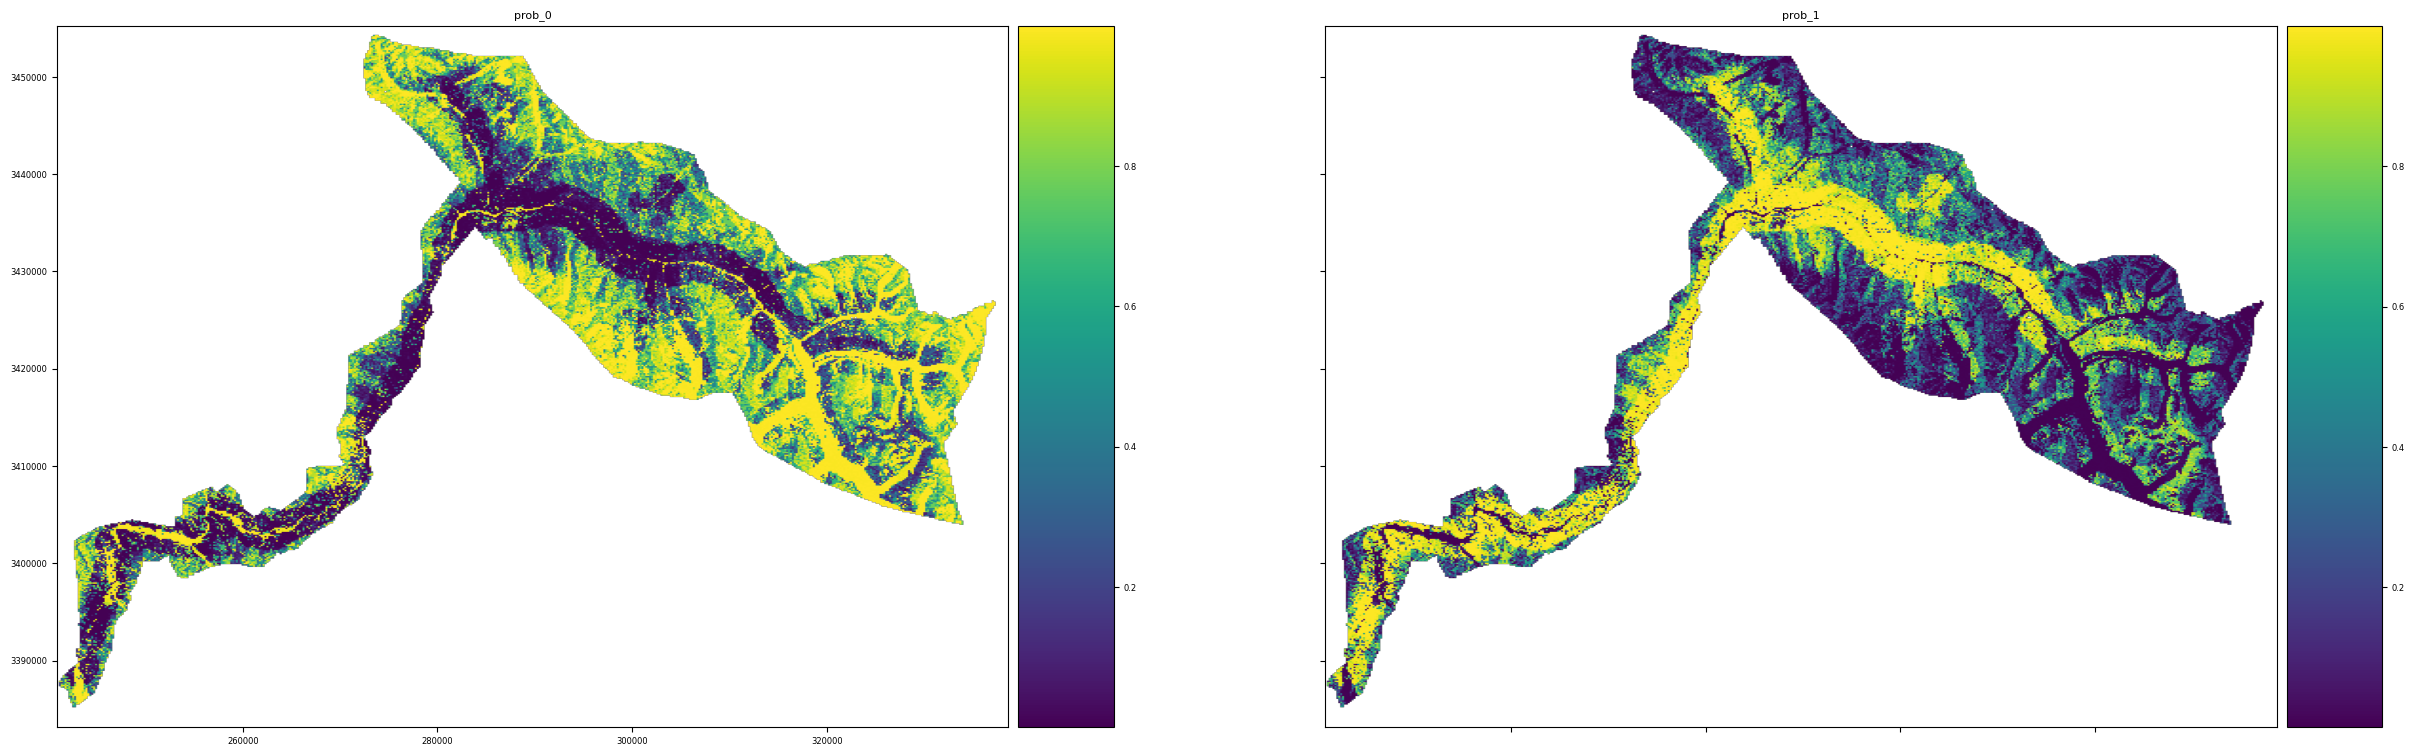

In [ ]:
result_xgb = stack.predict_proba(estimator = model_xgb)

result_xgb.plot(figsize =(30,30))

In [ ]:
result_xgb.write('/content/drive/MyDrive/Useful for writing and knowledge papers/xgb_gang_2025.tif',nodata=-9999)

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [/content/drive/MyDrive/Useful for writing and...
2        rows                                               7204
3        cols                                               9778
4         res              (9.99995258800289, 9.999952588002905)
5  nodatavals                                 [-9999.0, -9999.0]


Multilayer Pereceptron Workflow

In [ ]:
from sklearn.neural_network import MLPClassifier
classifier1 = MLPClassifier(
    early_stopping=True,
    n_iter_no_change=10,
    max_iter=300,
    random_state=42
)

mlp_flow = Pipeline([
    ('preproc', preprocessor),
    ('MLP', classifier1)
])

In [ ]:
acc_scorer_mlp = make_scorer(accuracy_score)
f1_scorer_mlp = make_scorer(f1_score)

grid_mlp = {
    'MLP__hidden_layer_sizes': [(8,), (16,), (8, 4), (16, 8)],
    'MLP__activation': ['relu', 'tanh'],
    'MLP__solver': ['adam', 'lbfgs'],
    'MLP__alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'MLP__learning_rate': ['constant', 'adaptive'],
    'MLP__learning_rate_init': [0.001, 0.01],
    'MLP__early_stopping': [True]
}

In [ ]:
# Instantiate the grid search model with 10-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_mlp = RandomizedSearchCV(
    mlp_flow,
    param_distributions=grid_mlp,
    cv=kfold,
    scoring=f1_scorer_mlp,
    n_iter=20,  # You can increase this to explore more combinations
    random_state=42,
    verbose=1,
    n_jobs=-1
)

model_mlp.fit(x_train, y_train)
best_mlp = model_mlp.best_estimator_
val_preds = best_mlp.predict(x_val)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
print("MLP Validation F1 Score:", f1_score(y_val, val_preds))
print("MLP Validation Classification Report:\n", classification_report(y_val, val_preds))
print("MLP Validation Accuracy:", accuracy_score(y_val, val_preds))

MLP Validation F1 Score: 0.8571428571428571
MLP Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.77      0.83        13
           1       0.80      0.92      0.86        13

    accuracy                           0.85        26
   macro avg       0.85      0.85      0.85        26
weighted avg       0.85      0.85      0.85        26

MLP Validation Accuracy: 0.8461538461538461


In [ ]:

y_pred_mlp_prob = best_mlp.predict_proba(x_test)
y_pred_mlp_prob = y_pred_mlp_prob[:,1]
y_pred_mlp_prob

test_preds = best_mlp.predict(x_test)

In [ ]:
print("MLP Test F1 Score:", f1_score(y_test, test_preds))
print("MLP Test Accuracy:", accuracy_score(y_test, test_preds))

print("MLP \nTest Classification Report:\n", classification_report(y_test, test_preds))

MLP Test F1 Score: 0.896551724137931
MLP Test Accuracy: 0.8846153846153846
MLP 
Test Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.87      0.93      0.90        14

    accuracy                           0.88        26
   macro avg       0.89      0.88      0.88        26
weighted avg       0.89      0.88      0.88        26



In [ ]:
model_mlp.best_params_

{'MLP__solver': 'lbfgs',
 'MLP__learning_rate_init': 0.001,
 'MLP__learning_rate': 'constant',
 'MLP__hidden_layer_sizes': (8,),
 'MLP__early_stopping': True,
 'MLP__alpha': 0.01,
 'MLP__activation': 'relu'}

array([<Axes: title={'center': 'prob_0'}>,
       <Axes: title={'center': 'prob_1'}>], dtype=object)

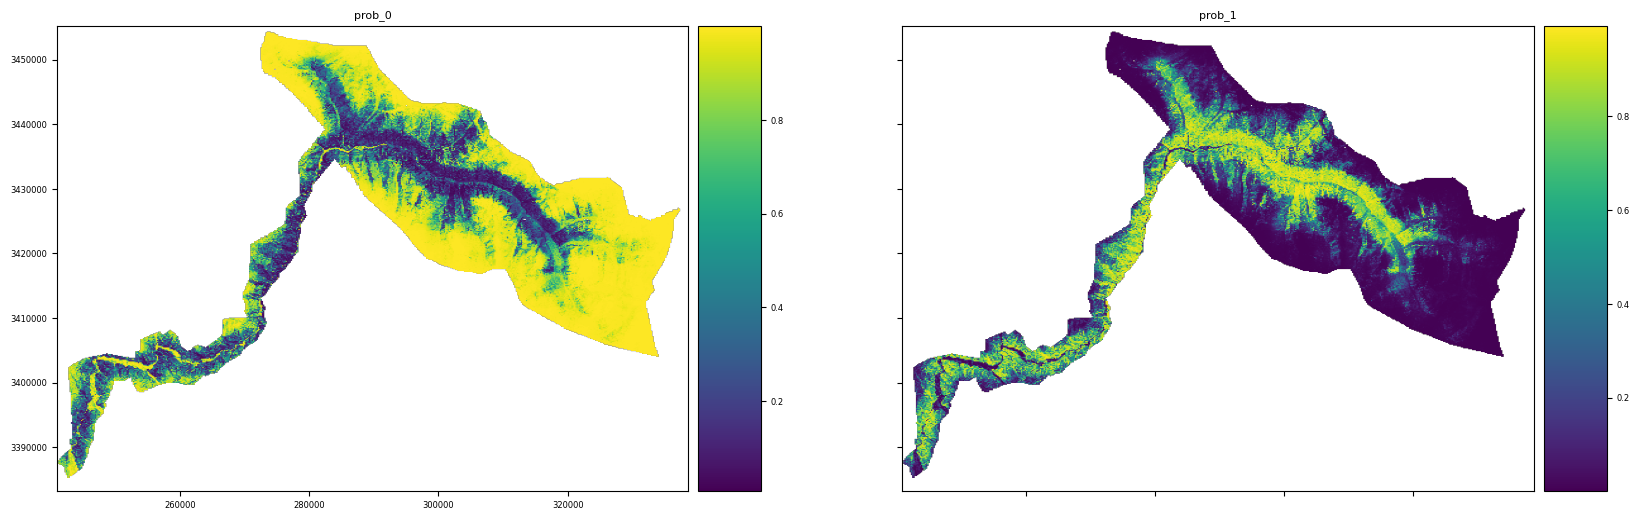

In [ ]:
result_mlp = stack.predict_proba(estimator = model_mlp)

result_mlp.plot(figsize =(20,20))

In [ ]:
result_mlp.write('/content/drive/MyDrive/Useful for writing and knowledge papers/mlp_gang_2025.tif',nodata=-9999)

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [/content/drive/MyDrive/Useful for writing and...
2        rows                                               7204
3        cols                                               9778
4         res              (9.99995258800289, 9.999952588002905)
5  nodatavals                                 [-9999.0, -9999.0]


Plotting the training and Validation loss curve for the two models

In [ ]:


# ------------------- XGBoost -------------------
final_xgb_model = XGBClassifier(
    learning_rate=0.05,
    max_depth=6,
    n_estimators=150,
    gamma=1,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


final_xgb_model.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    verbose=False
)
xgb_results = final_xgb_model.evals_result()
xgb_train_loss = xgb_results['validation_0']['logloss']
xgb_val_loss = xgb_results['validation_1']['logloss']

# ------------------- MLP -------------------
final_mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    learning_rate_init=0.001,
    activation='relu',
    solver='adam',
    alpha=0.001,
    validation_fraction=0.1,
    max_iter=200,
    random_state=42
)
n_epochs = 100
mlp_train_loss = []
mlp_val_loss = []

# First call to partial_fit must include classes
final_mlp_model.partial_fit(x_train, y_train, classes=np.unique(y_train))

for epoch in range(n_epochs):
    final_mlp_model.partial_fit(x_train, y_train)

    train_loss = final_mlp_model.loss_

    val_proba = final_mlp_model.predict_proba(x_val)[:, 1]
    val_loss = -np.mean(
        y_val * np.log(val_proba + 1e-8) + (1 - y_val) * np.log(1 - val_proba + 1e-8)
    )

    mlp_train_loss.append(train_loss)
    mlp_val_loss.append(val_loss)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:56:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


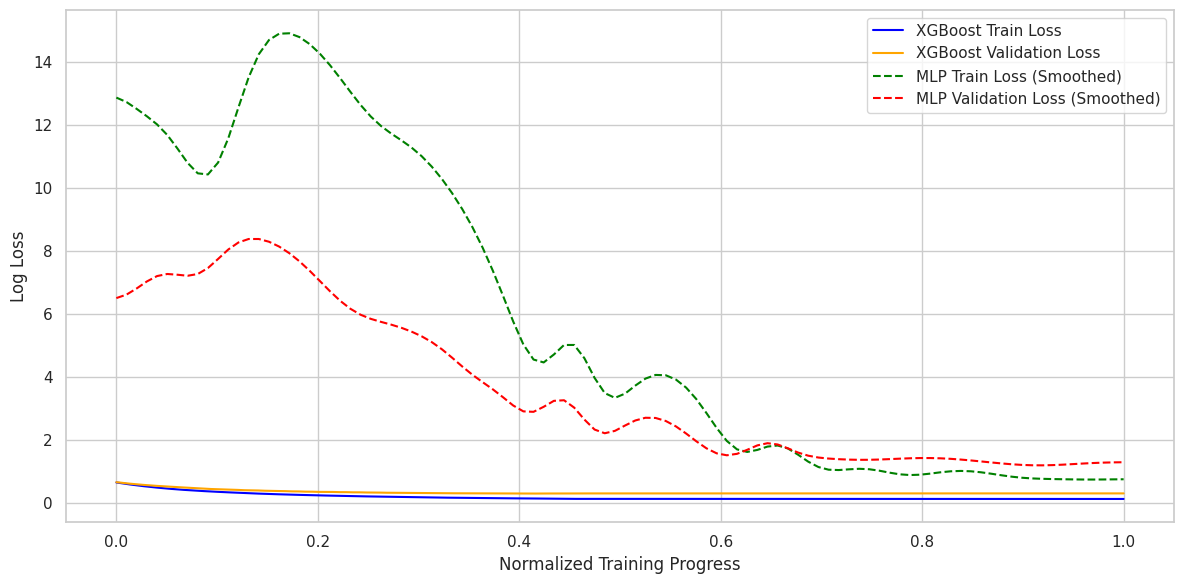

In [ ]:
 # for smoothing

# Smoothing MLP losses (for better comparison)
mlp_train_loss_smooth = gaussian_filter1d(mlp_train_loss, sigma=2)
mlp_val_loss_smooth = gaussian_filter1d(mlp_val_loss, sigma=2)

# Normalize x-axis lengths
max_len = max(len(xgb_train_loss), len(mlp_train_loss))
xgb_x = np.linspace(0, 1, len(xgb_train_loss))  # scaled to [0, 1]
mlp_x = np.linspace(0, 1, len(mlp_train_loss))

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# XGBoost
plt.plot(xgb_x, xgb_train_loss, label='XGBoost Train Loss', color='blue')
plt.plot(xgb_x, xgb_val_loss, label='XGBoost Validation Loss', color='orange')

# MLP
plt.plot(mlp_x, mlp_train_loss_smooth, label='MLP Train Loss (Smoothed)', linestyle='--', color='green')
plt.plot(mlp_x, mlp_val_loss_smooth, label='MLP Validation Loss (Smoothed)', linestyle='--', color='red')

# Labels
plt.xlabel('Normalized Training Progress')
plt.ylabel('Log Loss')
# plt.title('Unified Loss Curve: XGBoost vs MLP')
plt.legend()
plt.tight_layout()
plt.show()

Explainable Machine Learning using SHAP

In [ ]:
shap.initjs()

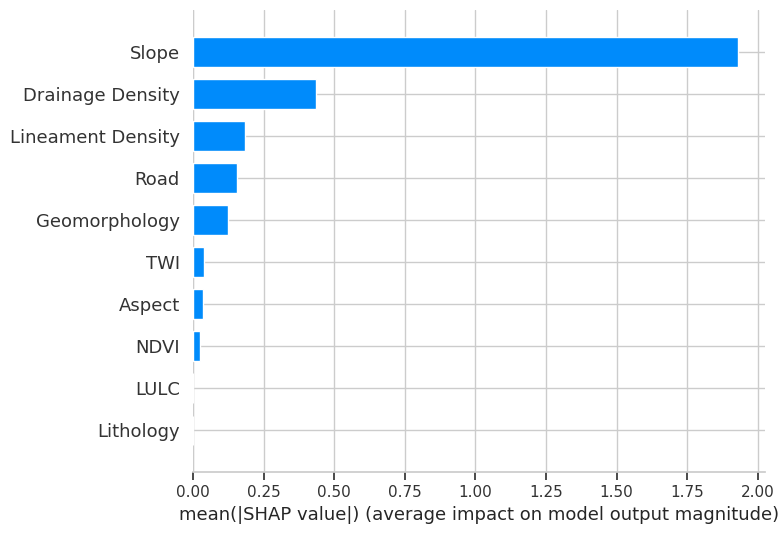

<Figure size 640x480 with 0 Axes>

In [ ]:
explainer_ = shap.TreeExplainer(final_xgb_model)
shap_values_ = explainer_.shap_values(x_train)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_, x_train, feature_names=df.columns, plot_type="bar")
# plt.title("SHAP Summary Plot for XGBoost Model (Feature Importance)")
plt.tight_layout()
plt.show()

SHAP Summary Plot

Raster Object Containing 10 Layers
    attribute                                             values
0       names  [geo, road, litho, LD, ndvi_T, twi, LULC, slop...
1       files  [geo.tif, road.tif, litho.tif, LD.tif, ndvi_T....
2        rows                                               7204
3        cols                                               9778
4         res              (9.99995258800289, 9.999952588002905)
5  nodatavals  [127.0, -3.4028230607370965e+38, 127.0, -3.402...


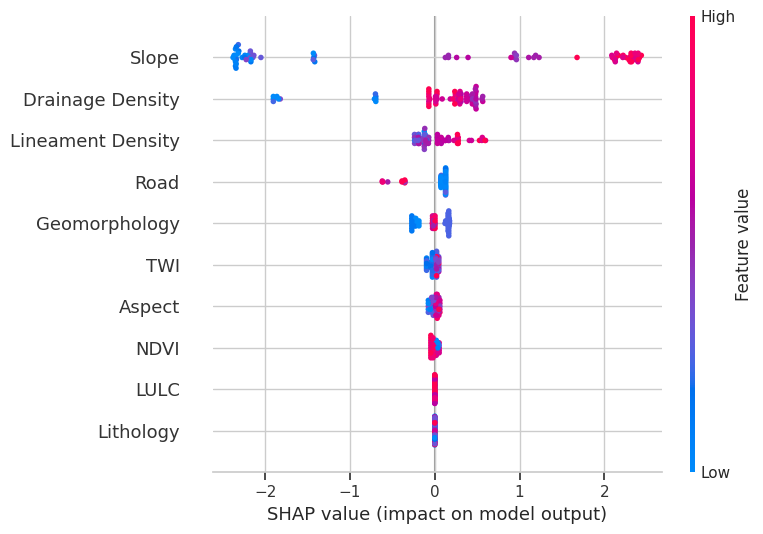

<Figure size 640x480 with 0 Axes>

In [ ]:
# Generate summary plot without displaying it immediately
shap.summary_plot(shap_values_, x_train, feature_names=df.columns, show=False)

# Save the figure after it's created
plt.savefig("/content/drive/MyDrive/Useful for writing and knowledge papers/shap_summary_plot.jpeg", dpi=400, bbox_inches='tight')

# Optional: Show the plot now
plt.show()


SHAP Dependence Plot

In [ ]:


top_features = ['Slope', 'Drainage Density', 'Lineament Density', 'Road']

shap_values_val = explainer_.shap_values(x_val)

for feature in top_features:

    shap.dependence_plot(
        feature,
        shap_values_val,
        x_val,
        feature_names=df.columns,
        interaction_index=None,
        show=False
    )


    fig = plt.gcf()  # Get current figure
    ax = plt.gca()   # Get current axis

    # Find and customize all scatter plots (SHAP adds multiple)
    for artist in ax.collections:
        if hasattr(artist, 'set_sizes'):
            artist.set_sizes([50])  # Size of points
            artist.set_alpha(0.6)   # Transparency
            artist.set_edgecolor('k')  # Black edge
            artist.set_linewidth(0.3)  # Edge thickness

    plt.xlabel(feature, fontsize=14)
    plt.ylabel(f'SHAP value for {feature}', fontsize=14)
    # plt.title(f"SHAP Dependence Plot: {feature}", fontsize=15)
    plt.tight_layout()


    filename = f"/content/drive/MyDrive/Useful for writing and knowledge papers/shap_dependence_{feature.replace(' ', '_')}.jpeg"
    plt.savefig(filename, dpi=400)
    plt.close()


Raster Object Containing 10 Layers
    attribute                                             values
0       names  [geo, road, litho, LD, ndvi_T, twi, LULC, slop...
1       files  [geo.tif, road.tif, litho.tif, LD.tif, ndvi_T....
2        rows                                               7204
3        cols                                               9778
4         res              (9.99995258800289, 9.999952588002905)
5  nodatavals  [127.0, -3.4028230607370965e+38, 127.0, -3.402...
Raster Object Containing 10 Layers
    attribute                                             values
0       names  [geo, road, litho, LD, ndvi_T, twi, LULC, slop...
1       files  [geo.tif, road.tif, litho.tif, LD.tif, ndvi_T....
2        rows                                               7204
3        cols                                               9778
4         res              (9.99995258800289, 9.999952588002905)
5  nodatavals  [127.0, -3.4028230607370965e+38, 127.0, -3.402...
